In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.1.0


In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [4]:
import time
from datetime import datetime

In [5]:
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

In [6]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
print(zarr_dataset.agents)
print(zarr_dataset.agents.shape)
n = zarr_dataset.agents.shape

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>
(1893736,)


In [8]:
# helper to convert a timedelta to a string (dropping milliseconds)
def deltaToString(delta):
    timeObj = time.gmtime(delta.total_seconds())
    return time.strftime('%H:%M:%S', timeObj)

class ProgressBar:
    
    # constructor
    #   maxIterations: maximum number of iterations
    def __init__(self, maxIterations):
        self.maxIterations = maxIterations
        self.granularity = 100 # 1 whole percent
    
    # start the timer
    def start(self):
        self.start = datetime.now()
    
    # check the progress of the current iteration
    #   # currentIteration: the current iteration we are on
    def check(self, currentIteration, chunked=False):
        if currentIteration % round(self.maxIterations / self.granularity) == 0 or chunked:
            
            percentage = round(currentIteration / (self.maxIterations - self.maxIterations / self.granularity) * 100)
            
            current = datetime.now()
            
            # time calculations
            timeElapsed = (current - self.start)
            timePerStep = timeElapsed / (currentIteration + 1)
            totalEstimatedTime = timePerStep * self.maxIterations
            timeRemaining = totalEstimatedTime - timeElapsed
            
            # string formatting
            percentageStr = "{:>3}%  ".format(percentage)
            remainingStr = "Remaining: {}  ".format(deltaToString(timeRemaining))
            elapsedStr = "Elapsed: {}  ".format(deltaToString(timeElapsed))
            totalStr = "Total: {}\r".format(deltaToString(totalEstimatedTime))
            
            print(percentageStr + remainingStr + elapsedStr + totalStr, end="")

    def end(self):
        print()

In [9]:
def getAgentsChunked(dataset, subsetPercent=1, chunks=10):

    datasetLength = round(len(dataset) * subsetPercent)
    chunkSize = round(datasetLength / chunks)
    
    pb = ProgressBar(datasetLength)
    pb.start()

    agents = []
    for i in range(0, datasetLength, chunkSize):

        agentsSubset = dataset[i:i+chunkSize]
        for j in range(0,len(agentsSubset)):

            agent = agentsSubset[j]
            track_id = agent[4]

            if track_id >= len(agents):
                agents.append([])

            data = []
            centroid = agent[0]
            yaw = agent[2]
            velocity = agent[3]
            data.append(centroid[0])
            data.append(centroid[1])
            data.append(yaw)
            data.append(velocity[0])
            data.append(velocity[1])
            agents[int(track_id)-1].append(data)
        pb.check(i, True)

    return agents

In [10]:
print(zarr_dataset.agents, "\n")
print(type(zarr_dataset.agents[0][0][0]))
print(type(zarr_dataset.agents[0][0]))
print(type(zarr_dataset.agents[0]))
print(type(zarr_dataset.agents))
agents = []
print(type(agents))

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only> 

<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.void'>
<class 'zarr.core.Array'>
<class 'list'>


In [22]:
subsetPercent = 1 #1*10**-2
print(subsetPercent)
agents = getAgentsChunked(zarr_dataset.agents, subsetPercent, 100)

0.01


In [23]:
def plotAgents(agents):
    r = lambda: random.randint(0,255)
    pb = ProgressBar(len(agents))
    pb.start()
    for i in range(0, len(agents)):
        agent = agents[i]
        centroid_x = []
        centroid_y = []
        for centroid in agent:
            centroid_x.append(centroid[0])
            centroid_y.append(centroid[1])
        plt.plot(centroid_x, centroid_y, 'o', color='#%02X%02X%02X' % (r(),r(),r()))
        pb.check(i)

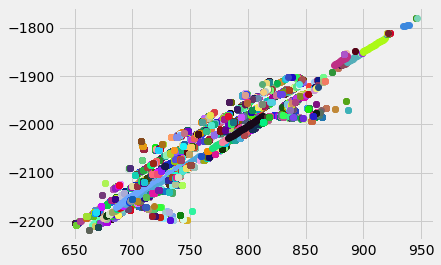

In [24]:
plotAgents(agents)

In [56]:
def normalizeAgents(agents):
    dataForNormalization = []
    pb = ProgressBar(len(agents))
    pb.start()
    for agent in agents:
        pb.check(0, True)
        for data in agent:
            for i in range(0, len(data)):
                feature = data[i]
                if i >= len(dataForNormalization):
                    dataForNormalization.append([])
                dataForNormalization[i].append(feature)
        
    
    first = True
    normalizedAgents = []
    pb = ProgressBar(len(dataForNormalization) * len(agents))
    pb.start()
    for i in range(0, len(dataForNormalization)):
        pb.end()
        data = dataForNormalization[i]
        min_ = np.min(data)
        max_ = np.max(data)
        print("max[{}]".format(i),max_)
        print("min[{}]".format(i),min_,"\n")
        
        for j in range(0, len(agents)):
            pb.check(i * j)
            if j >= len(normalizedAgents):
                normalizedAgents.append([])
                
            agent = agents[j]
            normalizedAgent = normalizedAgents[j]
            
            for k in range(0, len(agent)):
                if k >= len(normalizedAgent):
                    normalizedAgent.append([])
                data = agent[k]
                normalizedData = normalizedAgent[k]
                
                feature = data[i]
                normalizedFeature = (feature - min_) / (max_ - min_)
                if i == 0 and first:
                    print(feature)
                    print(normalizedFeature)
                    first = False
                
                if i >= len(normalizedData):
                    normalizedData.append(0)
                normalizedData[i] = normalizedFeature
    return normalizedAgents

In [57]:
import copy

In [58]:
normalizedAgents = normalizeAgents(agents)

  0%  Remaining: 00:07:33  Elapsed: 00:00:00  Total: 00:07:34
max[0] 946.3036499023438
min[0] 650.2347412109375
mean[0] 762.4895705341437
std[0] 49.888861375776976 

665.0342407226562
0.049986672282243336


  0%  Remaining: 01:08:19  Elapsed: 00:00:00  Total: 01:08:19
max[1] -1778.9434814453125
min[1] -2217.884521484375
mean[1] -2046.287387862089
std[1] 76.4486245293908 

 19%  Remaining: 00:00:02  Elapsed: 00:00:00  Total: 00:00:02
max[2] 3.0952168
min[2] -3.0764265
mean[2] 0.7753164
std[2] 0.6593328 

 40%  Remaining: 00:00:00  Elapsed: 00:00:00  Total: 00:00:01
max[3] 14.366165
min[3] -12.57888
mean[3] 0.06065339
std[3] 0.9954006 

 60%  Remaining: 00:00:00  Elapsed: 00:00:00  Total: 00:00:01


max[4] 14.134488
min[4] -19.352972
mean[4] 0.08874022
std[4] 1.5196944 



In [59]:
print(len(agents))
print(len(normalizedAgents),"\n")

print(agents[0][0][0])
print(normalizedAgents[0][0][0],"\n")

1790
1790 

665.0342407226562
0.049986672282243336 



In [60]:
def printAgentsInfo(agents, limit):
    print("len(agents)", len(agents), "\n")

    agentCentroidLengths = []
    agentsOverLimit = []
    for agent in agents:
        agentCentroidLengths.append(len(agent))
        if len(agent) > limit:
            agentsOverLimit.append(agent)

    print("len(agentCentroidLengths)",len(agentCentroidLengths), "\n")

    print("max",np.max(agentCentroidLengths))
    print("min",np.min(agentCentroidLengths))
    print("mean",np.mean(agentCentroidLengths))
    print("std",np.std(agentCentroidLengths), "\n")

    print("agents with {}+ history".format(limit),len(agentsOverLimit))
    return agentsOverLimit

In [61]:
limit = 10
agentsOverLimit = printAgentsInfo(normalizedAgents, limit)

len(agents) 1790 

len(agentCentroidLengths) 1790 

max 106
min 0
mean 10.664245810055865
std 12.394565662045224 

agents with 10+ history 532


In [31]:
def getTrainingSets(agents, limit):
    allTrainingSets = []
    totalNumberOfTrainingSets = 0
    
    pb = ProgressBar(len(agentsOverLimit))
    pb.start()
    for i in range(0, len(agentsOverLimit)):
        agent = agentsOverLimit[i]
        agentTrainingSets = []
        for i in range(limit, len(agent)-1):
            agentTrainingSet = []

            start = i - limit
            end = i
            output = i + 1

            agentTrainingSet.append(agent[start:end])
            agentTrainingSet.append(agent[output])
            agentTrainingSets.append(agentTrainingSet)

            totalNumberOfTrainingSets = totalNumberOfTrainingSets + 1

        allTrainingSets.append(agentTrainingSets)
        pb.check(i)

    print("len(allTrainingSets)", len(allTrainingSets))
    print("len(allTrainingSets[0])",len(allTrainingSets[0]), "\n")

    print("len(agentsOverLimit)",len(agentsOverLimit))
    print("len(agentsOverLimit[0]) - limit - 1",len(agentsOverLimit[0]) - limit - 1, "\n")

    print("totalNumberOfTrainingSets",totalNumberOfTrainingSets)
    return allTrainingSets

In [32]:
allTrainingSets = getTrainingSets(agentsOverLimit, limit)

len(allTrainingSets) 532
len(allTrainingSets[0]) 6 

len(agentsOverLimit) 532
len(agentsOverLimit[0]) - limit - 1 6 

totalNumberOfTrainingSets 7232


In [33]:
def flattenTrainingSets(allTrainingSets):
    allTrainingSetsFlattened_X = []
    allTrainingSetsFlattened_Y = []
    for allTrainingSet in allTrainingSets:
        for trainingSet in allTrainingSet:
            allTrainingSetsFlattened_X.append(trainingSet[0])
            allTrainingSetsFlattened_Y.append(trainingSet[1])
    print("len(allTrainingSetsFlattened_X)", len(allTrainingSetsFlattened_X))
    return allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y

In [34]:
allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y = flattenTrainingSets(allTrainingSets)

len(allTrainingSetsFlattened_X) 7232


In [35]:
def reshapeFlattenedTrainingSets(allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y):
    length = len(allTrainingSetsFlattened_X)
    depth = len(allTrainingSetsFlattened_X[0])
    channels = len(allTrainingSetsFlattened_X[0][0])

    print("length", length)
    print("depth", depth)
    print("channels",channels)
    print("length*depth*channels",length*depth*channels)

    allTrainingSetsFlattened_Input = np.reshape(allTrainingSetsFlattened_X, (length,depth,channels))
    allTrainingSetsFlattened_Output = np.reshape(allTrainingSetsFlattened_Y, (length,1,channels))

    print(allTrainingSetsFlattened_Input.shape[1])
    print(allTrainingSetsFlattened_Input.shape[2])
    
    return allTrainingSetsFlattened_Input, allTrainingSetsFlattened_Output

In [36]:
allTrainingSetsFlattened_Input = allTrainingSetsFlattened_X
allTrainingSetsFlattened_Output = allTrainingSetsFlattened_Y

In [37]:
allTrainingSetsFlattened_Input, allTrainingSetsFlattened_Output = reshapeFlattenedTrainingSets(allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y)

length 7232
depth 10
channels 5
length*depth*channels 361600
10
5


In [53]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(allTrainingSetsFlattened_Input.shape[1],allTrainingSetsFlattened_Input.shape[2])))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=allTrainingSetsFlattened_Input.shape[2]))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [54]:
from tensorflow import keras

In [55]:
# Fitting to the training set

class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self):
        self.epoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Epoch: {}             loss: {}\n".format(self.epoch, logs['loss']), end="")
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        if batch % 100 == 0:
            print("Epoch: {} batchs: {}% loss: {}\r".format(self.epoch, round(batch / self.params['steps'] * 100), logs['loss']), end="")

regressor.fit(allTrainingSetsFlattened_Input,allTrainingSetsFlattened_Output,epochs=2,batch_size=128,verbose=0,callbacks=[CustomCallback()])

Epoch: 0             loss: 0.036811310797929764
Epoch: 0             loss: 0.021618541330099106


In [41]:
dataset_path_test = dm.require('scenes/test.zarr')
zarr_dataset_test = ChunkedDataset(dataset_path_test)
zarr_dataset_test.open()
print(zarr_dataset_test)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [42]:
print(len(zarr_dataset_test.agents))

88594921


In [43]:
subsetPercent = 1*10**-3
print(subsetPercent)
agentsTest = getAgentsChunked(zarr_dataset_test.agents, subsetPercent, 1000)

0.001


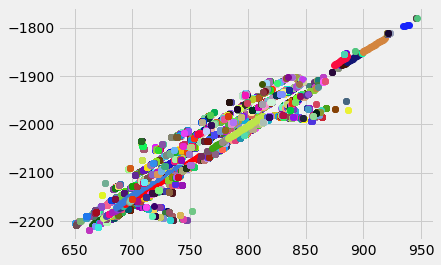

In [44]:
plotAgents(agents)

In [45]:
normalizedAgentsTest = normalizeAgents(agentsTest)

  0%  Remaining: 00:04:45  Elapsed: 00:00:00  Total: 00:04:45
max[0] 1176.3289794921875
min[0] 228.365234375
532.249755859375
0.32056555226888844


  0%  Remaining: 00:34:11  Elapsed: 00:00:00  Total: 00:34:11
max[1] -787.3958129882812
min[1] -2457.771728515625


 20%  Remaining: 00:00:03  Elapsed: 00:00:00  Total: 00:00:03
max[2] 3.1413598
min[2] -3.14054
 40%  Remaining: 00:00:01  Elapsed: 00:00:01  Total: 00:00:02
max[3] 13.556842
min[3] -14.46901
 60%  Remaining: 00:00:00  Elapsed: 00:00:01  Total: 00:00:02
max[4] 16.831251
min[4] -19.91049


In [46]:
agentsTestOverLimit = printAgentsInfo(normalizedAgentsTest, limit)

len(agents) 849 

len(agentCentroidLengths) 849 

max 1072
min 0
mean 104.40989399293287
std 128.88514146361 

agents with 10+ history 741


In [47]:
allTestingSets = getTrainingSets(agentsTestOverLimit, limit)

len(allTrainingSets) 532
len(allTrainingSets[0]) 6 

len(agentsOverLimit) 532
len(agentsOverLimit[0]) - limit - 1 6 

totalNumberOfTrainingSets 7232


In [48]:
allTestingSetsFlattened_X, allTestingSetsFlattened_Y = flattenTrainingSets(allTestingSets)

len(allTrainingSetsFlattened_X) 7232


In [49]:
allTestingSetsFlattened_Input, allTestingSetsFlattened_Output = reshapeFlattenedTrainingSets(allTestingSetsFlattened_X, allTestingSetsFlattened_Y)

length 7232
depth 10
channels 5
length*depth*channels 361600
10
5


In [50]:
max = len(allTestingSetsFlattened_Input)
print(max)
chunkSize = 1000
pb = ProgressBar(max)
pb.start()
predictedTestAgentCentroid = np.empty((1,5))
for i in range(0, max-chunkSize, chunkSize):#len(zarr_dataset.agents)):
    newPredictions = regressor.predict(allTestingSetsFlattened_Input[i:i+chunkSize])
    predictedTestAgentCentroid = np.concatenate((predictedTestAgentCentroid, newPredictions))
    pb.check(i, True)


7232


In [51]:
print(len(predictedTestAgentCentroid))
predictedTestAgentCentroid = predictedTestAgentCentroid[1:len(predictedTestAgentCentroid)]
print(len(predictedTestAgentCentroid))

7001
7000


In [52]:
randomSamples = 10
for i in range(0, len(predictedTestAgentCentroid), round(len(predictedTestAgentCentroid) / randomSamples)):
    testSet = allTestingSetsFlattened_Input[i]
    print(testSet[0][0])
    print(predictedTestAgentCentroid[i][0],"\n")

0.049986672282243336
0.30243784189224243 

0.09259599409828455
0.3008383512496948 

0.11722248300432528
0.30261534452438354 

0.26947243471325205
0.31007516384124756 

0.3032487677787941
0.29588013887405396 

0.38945755879502586
0.29375696182250977 

0.34457953575838013
0.301241397857666 

0.42373422242507564
0.3019721508026123 

0.4237455607773822
0.30220329761505127 

0.5681945199475632
0.30201148986816406 

